In [29]:
import glob
import pandas as pd
import requests
from io import BytesIO
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [288]:
csv_files=glob.glob('./face_box/*.csv')
len(csv_files)

18293

In [262]:
test_f=pd.read_csv(csv_files[5])

In [263]:
test_f

,photo_image_url,face_boxs
0,https://images.unsplash.com/photo-158507010536...,[[ 37 415 42 42]]


In [304]:
def cropface(image, box, fill=.5, ratios=(1,1)):
    shape = image.shape
    if len(shape) > 2 :
        h_img,w_img,c_img = shape
    else:
        h_img,w_img = shape

    Ry, Rx = ratios
    x,y,w,h = box
    print(box)
    

    new_y,new_x = Ry*y, Rx*x
    y_fill = max(0, new_y-h*fill)
    x_fill = max(0, new_x-w*fill)

    new_h, new_w = Ry*(h+y), Rx*(w+x)
    
    h_fill = min(h_img, new_h+h*fill)
    w_fill = min(w_img, new_w+w*fill)
    
    return image[int(y_fill):int(h_fill),
               int(x_fill):int(w_fill)]

In [266]:
test_f['photo_image_url'][0]

'https://images.unsplash.com/photo-1585070105361-a13b5623791c?width=512'

In [267]:
test_f['face_boxs'][0]

'[[ 37 415  42  42]]'

In [268]:
cords=[int(i) for i in test_f['face_boxs'][0].replace(']','').replace('[','').split(' ') if i]

In [269]:
cords[0:4]

[37, 415, 42, 42]

[37, 415, 42, 42]


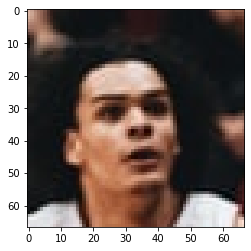

In [305]:
image_bytes_s = requests.get(test_f['photo_image_url'][0])

image_bytes_s = image_bytes_s.content
image_stream_s = BytesIO(image_bytes_s)
img_open_s = np.array(Image.open(image_stream_s))

plt.imshow(cropface(img_open_s, cords[0:4], fill=0.3))
og_shape=img_open_s.shape

In [306]:
image_bytes = requests.get(test_f['photo_image_url'][0].split('?')[0])

image_bytes = image_bytes.content
image_stream = BytesIO(image_bytes)
img_open = np.array(Image.open(image_stream))
new_shape=img_open.shape

In [307]:
og_shape, new_shape

((768, 512, 3), (5801, 3867, 3))

In [308]:
ratios=new_shape[0]/og_shape[0],new_shape[1]/og_shape[1]
ratios

(7.553385416666667, 7.552734375)

[37, 415, 42, 42]


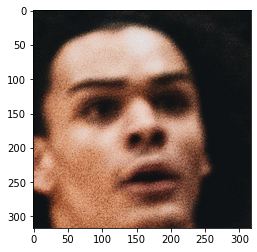

In [309]:
plt.imshow(cropface(img_open, cords[0:4], fill=0, ratios=ratios))

[37, 415, 42, 42]


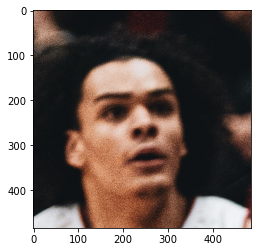

In [315]:
plt.imshow(cropface(img_open, cords[0:4], fill=2, ratios=ratios))

## Merge data and recalculate square

In [391]:
def parse_cords(cord_string):
    
    cords=[int(i) for i in cord_string.replace(']','').replace('[','').split(' ') if i]
    # print(cords)
    cords=np.reshape(cords, (len(cords)//4,4))
    return cords

def recal_box(box_cords, old_shape, new_shape):
    recal_boxes=[]
    
    for box in box_cords:
        Ry, Rx=new_shape[0]/og_shape[0],new_shape[1]/og_shape[1]

        x,y,w,h = box
        new_y, new_x = int(Ry*y), int(Rx*x)

        new_h, new_w = int(Ry*h), int(Rx*w)
        
        recal_boxes.append((new_x, new_y, new_w, new_h))

    return recal_boxes

def cropface(image, box, fill=.5, ratios=(1,1)):
    shape = image.shape
    if len(shape) > 2 :
        h_img,w_img,c_img = shape
    else:
        h_img,w_img = shape

    Ry, Rx = ratios
    x,y,w,h = box
    

    new_y,new_x = Ry*y, Rx*x
    y_fill = max(0, new_y-h*fill)
    x_fill = max(0, new_x-w*fill)

    new_h, new_w = Ry*(h+y), Rx*(w+x)
    
    h_fill = min(h_img, new_h+h*fill)
    w_fill = min(w_img, new_w+w*fill)
    
    return image[int(y_fill):int(h_fill),
               int(x_fill):int(w_fill)]


In [386]:
csv_files=glob.glob('./face_box/*.csv')
len(csv_files)

24832

In [387]:
for i, csv_p in enumerate(csv_files):
    test_recal=pd.read_csv(csv_p)
    if len(parse_cords(test_recal['face_boxs'][0]))> 4:
        print(i)
        break


331


In [388]:
test_recal=pd.read_csv(csv_files[192])
tsd=parse_cords(test_recal['face_boxs'][0])

In [389]:
tsd

array([[164,  79, 181, 181]])

[[164  79 181 181]]
[(1199, 577, 1323, 1323)]


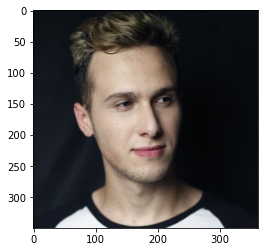

In [397]:
test_recal=pd.read_csv(csv_files[192])

image_bytes_s = requests.get(test_recal['photo_image_url'][0])

image_bytes_s = image_bytes_s.content
image_stream_s = BytesIO(image_bytes_s)
img_open_s = np.array(Image.open(image_stream_s))

image_bytes = requests.get(test_recal['photo_image_url'][0].split('?')[0])
image_bytes = image_bytes.content
image_stream = BytesIO(image_bytes)
img_open = np.array(Image.open(image_stream))

og_shape=img_open_s.shape
new_shape=img_open.shape

print(parse_cords(test_recal['face_boxs'][0]))
new_box=recal_box(parse_cords(test_recal['face_boxs'][0]),og_shape, new_shape)
print(new_box)
plt.imshow(cropface(img_open_s, parse_cords(test_recal['face_boxs'][0])[0]))

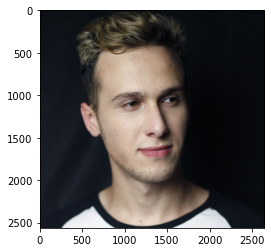

In [398]:
plt.imshow(cropface(img_open, new_box[0]))

In [401]:
csv_files = glob.glob('./face_box/*.csv')

result_dict = {
    'photo_image_url': [],
    'face_box_cords': []
}

for i, csv in enumerate(csv_files):
    
    cur = pd.read_csv(csv)
    try:
        image_bytes_s = requests.get(cur['photo_image_url'][0])

        image_bytes_s = image_bytes_s.content
        image_stream_s = BytesIO(image_bytes_s)
        img_open_s = np.array(Image.open(image_stream_s))

        image_bytes = requests.get(cur['photo_image_url'][0].split('?')[0])
        image_bytes = image_bytes.content
        image_stream = BytesIO(image_bytes)
        img_open = np.array(Image.open(image_stream))

        og_shape = img_open_s.shape
        new_shape = img_open.shape    

        result_dict['face_box_cords'].append(recal_box(parse_cords(cur['face_boxs'][0]),og_shape, new_shape))
        # result_dict['face_box_cords'].append(parse_cords(cur['face_boxs'][0]))
        result_dict['photo_image_url'].append(cur['photo_image_url'][0])
    except:
        print(f'error with {csv}')
    print(f'{i}/{len(csv_files)}', end='\r')
    

error with ./face_box/photo-1555135346-aa6a5344eae8.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (103312192 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (142686390 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (131072000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (118800000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1591583081530-3546d9d24173.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/JpegImagePlugin.py:812: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (138007760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (159575136 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (96992896 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (150165000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (124913322 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (91849845 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (139489119 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1530802280117-84084b1557f1.csv
error with ./face_box/photo-1585730308808-e6c0bea30ab7.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (97843296 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (128819200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1594063792116-7f18e270d03a.csv
error with ./face_box/photo-1594548844082-c07594d49dab.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (109256532 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1538446159817-a94e937bbac7.csv
error with ./face_box/photo-1590818463185-708e6515d4a2.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (173325240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1588450699956-f3b639896713.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (133958473 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (123454321 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (98679324 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (99878400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1591612254902-157c5365483d.csv
error with ./face_box/photo-1558262808-3ecd7cd52cdc.csv
error with ./face_box/photo-1584897426262-ab8747c85889.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (124087680 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error with ./face_box/photo-1593096719764-5a568b271e3a.csv


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (94330880 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [402]:
final_merge = pd.DataFrame.from_dict(result_dict)

In [405]:
final_merge.head()

,photo_image_url,face_box_cords
0,https://images.unsplash.com/photo-149490027836...,"[(1498, 2289, 385, 385)]"
1,https://images.unsplash.com/photo-149596972476...,"[(2996, 1023, 528, 529)]"
2,https://images.unsplash.com/photo-156477844114...,"[(2119, 479, 749, 749)]"
3,https://images.unsplash.com/photo-159331799366...,"[(178, 989, 210, 118)]"
4,https://images.unsplash.com/photo-153817186792...,"[(1754, 1436, 334, 334)]"


In [404]:
final_merge.to_csv('./merge_face_cords.csv', sep=';', index=False)

In [338]:
final_merge=pd.read_csv('./merge_face_cords.csv', sep=';')

In [339]:
final_merge.head()

,photo_image_url,face_box_cords
0,https://images.unsplash.com/photo-149490027836...,"[(1789, 2734, 460, 460)]"
1,https://images.unsplash.com/photo-149596972476...,"[(1925, 1484, 339, 767)]"
2,https://images.unsplash.com/photo-156477844114...,"[(2371, 1207, 838, 1888)]"
3,https://images.unsplash.com/photo-159331799366...,"[(211, 2344, 249, 280)]"
4,https://images.unsplash.com/photo-153817186792...,"[(1744, 3215, 332, 748)]"


In [381]:
final_merge['photo_image_url']=final_merge['photo_image_url'].str.split('?').str[0]

In [382]:
final_merge['photo_image_url'].iloc[10]

'https://images.unsplash.com/photo-1594097345019-b355d3f079b7'

In [383]:
final_merge.to_csv('./merge_face_cords_final.csv', sep=';', index=False)